In [1]:
import numpy as np
import pandas as pd

from scripts.wrangling_funs import read_and_clean_fines_data, pivot_fines_longer

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read in data, remove zero values for price and convert to long format
fines = (
    read_and_clean_fines_data(path="./data/scraped_fines.csv")
    .pipe(pivot_fines_longer)
)

In [3]:
# df showing article next to how often it was referenced.
n_citations = (
    fines
    .value_counts('article_number')
    .reset_index(name='count')
    .sort_values('article_number')
)

## Creating a dataset for Modelling

In [4]:

MIN_CITATIONS = 30
INTEREST_VARS = ['year', 'article_number']

index = ['id', 'total_fine_euro'].extend(INTEREST_VARS)

print(index)

# pivot data
gdpr_model_data = (
    fines
    .assign(
        violated=1,
        total_fine_euro = lambda x: np.log10(x.total_fine_euro),
        year            = lambda x: x.date.dt.year
    )
    .merge(
        n_citations.query(f'count >= {MIN_CITATIONS}'),
        how='inner', left_on='article_number', right_on='article_number'
        )
    .pivot_table(values=['violated'], index=['id', 'total_fine_euro'] + INTEREST_VARS)
    .unstack(level=-1, fill_value=0)
)

# sort out indexing
gdpr_model_data.columns = gdpr_model_data.columns.droplevel(0)
gdpr_model_data.columns.name = None

gdpr_model_data.columns = ['A' + str(col) for col in gdpr_model_data.columns]

gdpr_model_data = pd.get_dummies(gdpr_model_data.reset_index())

None


In [5]:
gdpr_model_data

,id,total_fine_euro,year,A2,A5,A6,A7,A9,A12,A13,...,A17,A21,A24,A25,A28,A31,A32,A33,A35,A58
0,1,3.972203,2019,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2,3.397940,2019,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,3,4.778151,2019,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,3.903090,2019,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,5.176091,2019,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1559,1696,4.095169,2022,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1560,1698,3.301030,2020,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1561,1699,3.397940,2020,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1562,1700,4.301030,2020,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Creating a Dataset for Modelling

# TODO:: return to -> decide to delete
# pivot data
gdpr_model_data = (
    overmin_incidence
    .assign(violated=1, year = lambda x: x.date.dt.year, total_fine_euro = lambda x: np.log10(x.total_fine_euro))
    .loc[:, ['id','year', 'country', 'total_fine_euro', 'article_number', 'violated']]
    .query('year > 2000')
    .pivot_table(values=['violated'], index=['id', 'year', 'country', 'total_fine_euro', 'article_number'])
    .unstack(level=-1, fill_value=0)
)

# sort out indexing
gdpr_model_data.columns = gdpr_model_data.columns.droplevel(0)
gdpr_model_data.columns.name = None

gdpr_model_data.columns = ['A' + str(col) for col in gdpr_model_data.columns]

gdpr_model_data = gdpr_model_data.reset_index()

# Regressing Article on Total Fine Price

In [6]:
import statsmodels.api as sm

In [7]:
gdpr_model_data.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
id,1564.0,833.065217,489.528139,1.000000,408.75000,821.500000,1252.250000,1701.000000
total_fine_euro,1564.0,4.026971,1.007934,1.447158,3.30103,3.845098,4.645893,9.079181
year,1564.0,2020.564578,5.120960,1970.000000,2020.00000,2021.000000,2022.000000,2023.000000
A2,1564.0,0.026854,0.161709,0.000000,0.00000,0.000000,0.000000,1.000000
A5,1564.0,0.527494,0.499403,0.000000,0.00000,1.000000,1.000000,1.000000
A6,1564.0,0.350384,0.477243,0.000000,0.00000,0.000000,1.000000,1.000000
A7,1564.0,0.023657,0.152028,0.000000,0.00000,0.000000,0.000000,1.000000
A9,1564.0,0.069054,0.253627,0.000000,0.00000,0.000000,0.000000,1.000000
A12,1564.0,0.111893,0.315335,0.000000,0.00000,0.000000,0.000000,1.000000
A13,1564.0,0.196292,0.397319,0.000000,0.00000,0.000000,0.000000,1.000000


In [8]:
X = gdpr_model_data.drop(columns=["id", "total_fine_euro"])
y = gdpr_model_data.total_fine_euro

mod = sm.OLS(y, X.assign(constant=1).astype('float'))
res = mod.fit()

coefs = pd.concat([res.params, res.conf_int()], axis=1)

coefs.columns = ['estimate', 'ci0', 'ci1']

In [9]:
# make a nice coeficient table for plotting
coefTable = (
    coefs
    .reset_index(names='coef')
    .assign(
        ci_length = lambda x: x.ci1 - x.estimate,
        hits0     = lambda x: (0 > x.ci0) & (0 < x.ci1)
    )
    .loc[lambda x: x.coef != 'constant', ['coef', 'estimate', 'ci_length', 'hits0']]
)

In [10]:
coefTable.head(2)

,coef,estimate,ci_length,hits0
0,year,-0.001622,0.009011,True
1,A2,-0.456740,0.297996,False


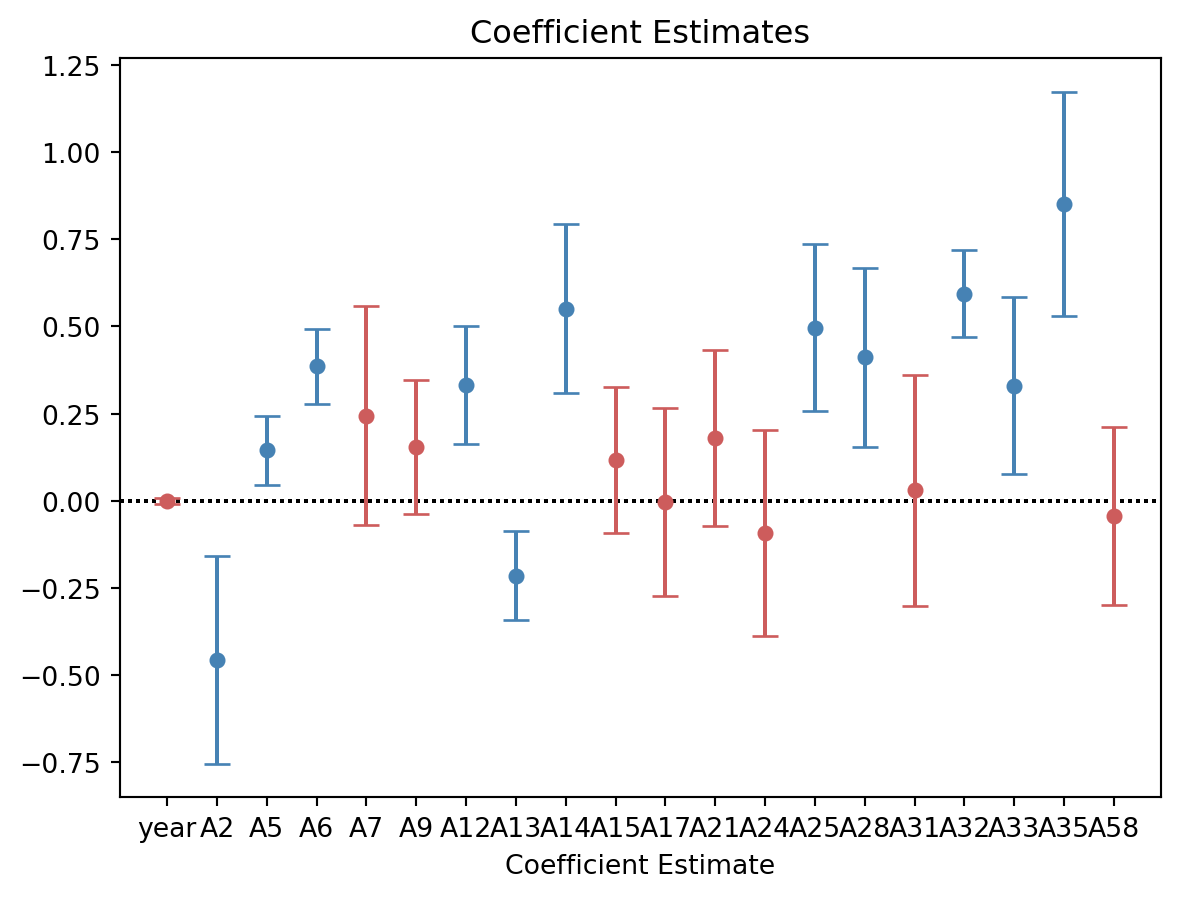

In [11]:
colors = {'True': 'indianred', 'False': 'steelblue'}

fig, ax = plt.subplots()

ax.axhline(y=0, color="black", linestyle=(0, (1, 1)))
ax.set(ylabel=None, xlabel="Coefficient Estimate", title="Coefficient Estimates", xticks=coefTable.index, xticklabels=coefTable.coef)

for hit_type in np.unique(coefTable.hits0):
    color = colors[str(hit_type)]
    df_subset = coefTable.query(f'hits0 == {hit_type}')
    ax.errorbar(
        df_subset.index, df_subset.estimate, yerr=df_subset.ci_length,
        marker='o', color=color, ls='', ms=5, capsize=5, label=hit_type
    )

plt.show()